# Введение

# План семинара
Сегодняшний план такой:

* Постановка задачи
* Обработка данных
    * Знакомство с данными
    * Поиск data leakage
    * Обработка пропущенных значений
    * Обработка категориальных значений
    * Поиск выбросов
* Применение KNN на полученных данных

# Бизнес-задача

## Цена квартиры
<img src="https://i.ibb.co/yfxgLRF/photo-2022-07-16-19-34-07.jpg" alt="photo-2022-07-16-19-34-07" border="0" height=700>
<img src="https://i.ibb.co/GQWhmNw/photo-2022-07-16-19-34-26.jpg" alt="photo-2022-07-16-19-34-26" border="0" height=700>

Уметь оценивать стоимость недвижимости может быть ужасно выгодно. Первые применения, которые приодят в голову:
* Помощь покупателям в выборе квартиры, как это делает ЦИАН
* Помощь продавцам в установке справедливой цены, как это делает ЦИАН
* Поиск недооцененных квартир, для покупки и перепродажи

Мы видим, что хорошо сделанная модель дл яоценки стоимости квартиры может принести огромную прибыль ее создателю. Давайте попробуем применить полученные нами знания о пайплайне МО для решения этой задачи.

# Постановка задачи

Данные мы опять же возьмем с сайта https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot?resource=download
Данные о продажах квартир были получены с помощью скрейпинга сайта Domain.com.au (скрейпинг - загрузка веб сайтов внутри кода и извлечение оттуда информации). Все квартиры продаются в Мельбурне.
У нас есть много разнородных признаков и одна целевая переменная - Price.

# Обработка данных

In [1]:
import pandas as pd

data = pd.read_csv('../datasets/melb_data.csv')
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Посмотрим на все доступные колонки


In [2]:
X = data.drop(columns='Price')
y = data['Price']

In [3]:
X

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


Всего у нас 20 признаков и 13580 обучающих объектов


## Train/validation/test split не нужен

Сейчас мы вообще не будем делить наши данные.

Тестовую часть, как и в предыдущем ноутбуке, мы опустим. Хотя важно помнить, что она критически важная для моделей, которые вы будете строить для реальных прменений!

Валидационная часть в данном случае не нужна, так как промежуточные метрики во время разработки модели мы будем отслеживать по кросс-валидации, которая не требует отдельных валидационнных данных.

<img src="https://i.ibb.co/xC3vXT8/2022-07-16-20-06-36.png" alt="2022-07-16-20-06-36" border="0">

## Найдем лики

В следующем шаге мы продйемся по всем признакам и посмотрим на них подрбонее, когда будем делить на численные категориальные итд. Сейчас нас интересует только один признак -- Method. Вот такое описание у него на страничке, с которой мы загрузили наши данные.

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold§ prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Если в кратце, то S значит, что продажа случилась, SP что продажа случилась раньше, чем указанная дата, SN что не известно, случилась ли продажа итд. Понятно, что этот признак не будет доступен во время применения нашей модели.

In [4]:
X = X.drop(columns='Method')

# Найдем пропущеные значения

In [5]:
import numpy as np

np.nan  # - так обычно выглдят пропущенные значения

nan

In [6]:
X.isna()

,Suburb,Address,Rooms,Type,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
13576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
13577,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
13578,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


Пропущенные значения в табличках могут быть не только np.nan, но любыми другими значениями, которые сильно сложнее фильтровать. Например, вместо пропущенного значения может стоять строчка "missing". Сейчас мы не будем рассматривать такую возможность и понадеемся на того, кто собирал данные.

In [7]:
X.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

Теперь нам нужно решить, что делать с колонками. Прочитаем их описание

* Car: Number of carspots

Число пропущенных парковочных мест очень мало. Попробуем заменить все пропущенные значения на среднее по датасету.

In [8]:
# Хотим выполнить X.loc[X['Car'].isna(), 'Car'] = X['Car'].mean()

In [9]:
X['Car'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
13575    False
13576    False
13577    False
13578    False
13579    False
Name: Car, Length: 13580, dtype: bool

In [10]:
X.loc[X['Car'].isna(), 'Car']

12221   NaN
12247   NaN
12259   NaN
12320   NaN
12362   NaN
         ..
13496   NaN
13508   NaN
13522   NaN
13524   NaN
13550   NaN
Name: Car, Length: 62, dtype: float64

In [11]:
X.loc[X['Car'].isna(), 'Car'] = X['Car'].mean()


* BuildingArea: Building Size

Это значение отсутствует у половины примеров в нашем датасете. Скорее всего это очень важный признак, но у нас нет никакой надежды достать его реальное значение для половины обхектов.


In [12]:
X = X.drop(columns='BuildingArea')


* CouncilArea: Governing council for the area

Пропущено достаточно много значений признака. Понятно, что мы можем посмотреть на ближайшие дома, определив их по долготе и широте, а потом взять их значение CouncilArea, но признак вряд ли очень полезный, поэтому мы его выкинем.


In [13]:
X = X.drop(columns='CouncilArea')


* YearBuilt: not specified

# Дата постройки отсутсвтует у достаточно большого числа объявлений. Мы заменим значение на среднее по датасету + добавим новую бинарную колонку, в которую пропишем 1, если YearBuilt не был указан. Таким образом, мы избавимся от пропущенного значения, не выкинем колонку или много данных и при этом сохраним информацию о том, что у некоторых обхектов отсутствовал признак.

In [14]:
X['YearBuiltWasMissing'] = X['YearBuilt'].isna()
X.loc[X['YearBuilt'].isna(), 'YearBuilt'] = X['YearBuilt'].mean()

# Определение типов признаков

In [15]:
list(zip(X.columns, X.dtypes))

[('Suburb', dtype('O')),
 ('Address', dtype('O')),
 ('Rooms', dtype('int64')),
 ('Type', dtype('O')),
 ('SellerG', dtype('O')),
 ('Date', dtype('O')),
 ('Distance', dtype('float64')),
 ('Postcode', dtype('float64')),
 ('Bedroom2', dtype('float64')),
 ('Bathroom', dtype('float64')),
 ('Car', dtype('float64')),
 ('Landsize', dtype('float64')),
 ('YearBuilt', dtype('float64')),
 ('Lattitude', dtype('float64')),
 ('Longtitude', dtype('float64')),
 ('Regionname', dtype('O')),
 ('Propertycount', dtype('float64')),
 ('YearBuiltWasMissing', dtype('bool'))]

dtype('O') означает, что в колонке находятся какие-то Python объекты. В больинстве случаев это значит, что там лежат строки.

dtype('float64') означает, что в колонке находятся числа с плавающей точкой

dtype('bool') означает, что в колонке находятся True или False

In [16]:
X

,Suburb,Address,Rooms,Type,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,YearBuiltWasMissing
0,Abbotsford,85 Turner St,2,h,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,1964.684217,-37.79960,144.99840,Northern Metropolitan,4019.0,True
1,Abbotsford,25 Bloomburg St,2,h,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,1900.000000,-37.80790,144.99340,Northern Metropolitan,4019.0,False
2,Abbotsford,5 Charles St,3,h,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,1900.000000,-37.80930,144.99440,Northern Metropolitan,4019.0,False
3,Abbotsford,40 Federation La,3,h,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,1964.684217,-37.79690,144.99690,Northern Metropolitan,4019.0,True
4,Abbotsford,55a Park St,4,h,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,2014.000000,-37.80720,144.99410,Northern Metropolitan,4019.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,1981.000000,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,False
13576,Williamstown,77 Merrett Dr,3,h,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,1995.000000,-37.85927,144.87904,Western Metropolitan,6380.0,False
13577,Williamstown,83 Power St,3,h,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,1997.000000,-37.85274,144.88738,Western Metropolitan,6380.0,False
13578,Williamstown,96 Verdon St,4,h,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,1920.000000,-37.85908,144.89299,Western Metropolitan,6380.0,False


In [17]:
categorical_cols = [
    'Suburb',
    'Type',
    'Regionname',
    'YearBuiltWasMissing'
]

numerical_cols = [
    'Rooms',
    'Distance',
    'Bedroom2',
    'Bathroom',
    'Car',
    'Landsize',
    'YearBuilt',
    'Lattitude',
    'Longtitude',
    'Propertycount'
]


cols_to_drop = [
    'Address',
    'SellerG',
    'Date',
    'Postcode'
]

У нас есть сомнения по поводу того, включать ли Suburb как категориальный признак. Давайте посмотрим, сколько возможных значений существует.

In [18]:
# Исследование колонок Address  Postcode  Suburb

## Отличный пример бининга

In [19]:
suburb_counts = X['Suburb'].value_counts()
suburb_counts

Suburb
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Attwood             1
Wallan              1
New Gisborne        1
Plumpton            1
Monbulk             1
Name: count, Length: 314, dtype: int64

In [20]:
is_rare_suburb = X['Suburb'].apply(lambda x: suburb_counts[x] < 200)
X.loc[is_rare_suburb, 'Suburb'] = 'RareSuburb'

In [21]:
X['Suburb'].value_counts()

Suburb
RareSuburb        11829
Reservoir           359
Richmond            260
Bentleigh East      249
Preston             239
Brunswick           222
Essendon            220
South Yarra         202
Name: count, dtype: int64

In [22]:
X = X.drop(columns=cols_to_drop)

## One-hot-encoding

In [23]:
X = pd.get_dummies(X, columns=categorical_cols)

In [24]:
X

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Propertycount,...,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,YearBuiltWasMissing_False,YearBuiltWasMissing_True
0,2,2.5,2.0,1.0,1.0,202.0,1964.684217,-37.79960,144.99840,4019.0,...,False,False,True,False,False,False,False,False,False,True
1,2,2.5,2.0,1.0,0.0,156.0,1900.000000,-37.80790,144.99340,4019.0,...,False,False,True,False,False,False,False,False,True,False
2,3,2.5,3.0,2.0,0.0,134.0,1900.000000,-37.80930,144.99440,4019.0,...,False,False,True,False,False,False,False,False,True,False
3,3,2.5,3.0,2.0,1.0,94.0,1964.684217,-37.79690,144.99690,4019.0,...,False,False,True,False,False,False,False,False,False,True
4,4,2.5,3.0,1.0,2.0,120.0,2014.000000,-37.80720,144.99410,4019.0,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,16.7,4.0,2.0,2.0,652.0,1981.000000,-37.90562,145.16761,7392.0,...,False,False,False,False,True,False,False,False,True,False
13576,3,6.8,3.0,2.0,2.0,333.0,1995.000000,-37.85927,144.87904,6380.0,...,False,False,False,False,False,False,True,False,True,False
13577,3,6.8,3.0,2.0,4.0,436.0,1997.000000,-37.85274,144.88738,6380.0,...,False,False,False,False,False,False,True,False,True,False
13578,4,6.8,4.0,1.0,5.0,866.0,1920.000000,-37.85908,144.89299,6380.0,...,False,False,False,False,False,False,True,False,True,False


# Поиск выбросов

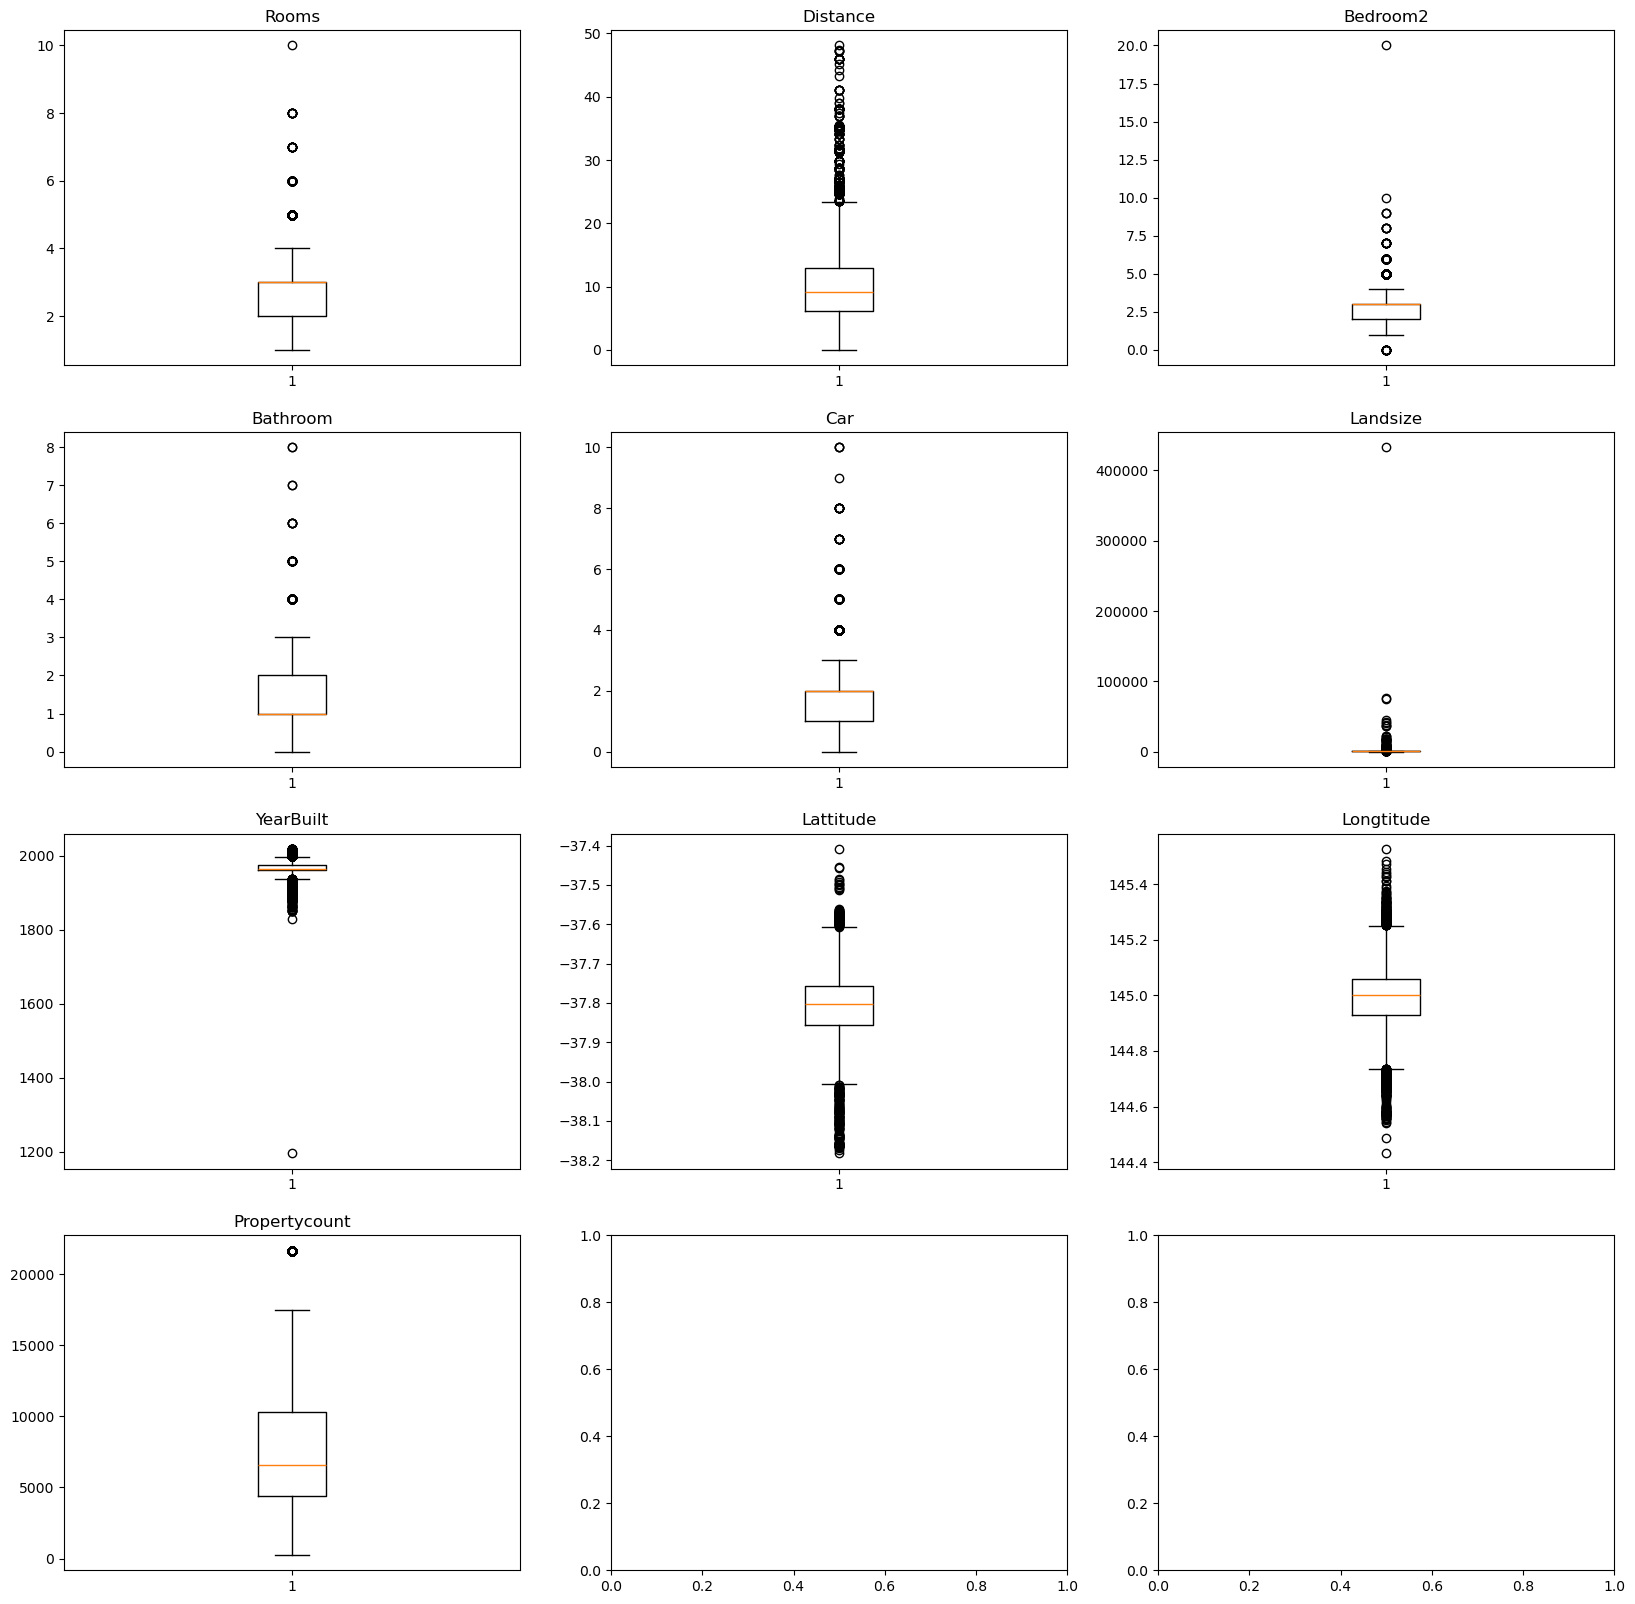

In [25]:
import matplotlib.pyplot as plt

for ax, num_col_name in zip(plt.subplots(4, 3, figsize=(20,20))[1].flatten(), numerical_cols):
    ax.set_title(num_col_name)
    ax.boxplot(X[num_col_name])

Если бы мы обучали алгоритм вроде LinearRegression, про который вы узнаете позже, то нам пришлось бы убирать выбросы, но мы будем использовать KNN, который достаточно хорошо себя ведет и при наличии выбросов.

## Standard Scaler

На последок, мы проведем стандартизацию признаков, про которую говорили раньше. Сейчас мы сдлеаем очень плохую и неправильную ошибку, чтобы не загромождать сегодняшнее видео. Мы посчитаем среднее и дисперсси признаков по всему датасету, а не только по обучающей части.

Как вы помните, при кроссвалидации мы выделяем обучающую и валидационную часть только в самом конце, поэтмоу проведя стандартизацию сейчас мы создадим утечку данных. Чтобы этой утечки не допускать нужно использовать sklearn.piplines или пользоваться первым метдом проведение кросс валидации, про который мы поговорим через KFold.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Обучение KNN и кроссвалидация

Напомним, как работает кроссвалидация
<img src="https://i.ibb.co/xC3vXT8/2022-07-16-20-06-36.png" alt="2022-07-16-20-06-36" border="0">


Для првоедения кросс валидации есть несколько путей.

Первый, который мы попробуем, это прямое использование sklearn.model_selection.KFold, который выдаст нам разделения на трейн и тест.

In [27]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(5)

```python
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

cv = KFold(n_splits=5)
errors = []

for train_idx, val_idx in tqdm(list(cv.split(X)), desc='KFold CV'):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    errors.append(mean_squared_error(y_true=y_val, y_pred=pred_val))
```

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

cv = KFold(n_splits=5)
errors = []

for train_idx, val_idx in tqdm(list(cv.split(X)), desc="KFold CV"):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    errors.append(
        mean_squared_error(y_val, pred_val)
    )

print()
print('Metrics')
print(errors)
print('RMSE=', np.mean(errors) ** 0.5)

KFold CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Legion\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Legion\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Legion\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Legion\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^


Metrics
[152221914618.40787, 139844557104.8016, 151519653156.14096, 125234587086.32564, 140367156220.8642]
RMSE= 376613.29455730587


Есть также второй более простой способ -- использование cross_val_score

In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=5)
scores

array([0.65407151, 0.67056376, 0.64918064, 0.63586118, 0.63812613])

cross_val_score выдает стандартный скор для всех регрессоров -- R_squared. Но мы не хотим его, поэтому передадим свой собтсвенный скорер

In [30]:
from sklearn.metrics import make_scorer
scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred),
                     greater_is_better=False)
errors = cross_val_score(knn, X, y, cv=5, scoring=scorer)

print()
print('Metrics')
print(errors)
print('RMSE=', np.mean(-errors) ** 0.5)


Metrics
[-1.52221915e+11 -1.39844557e+11 -1.51519653e+11 -1.25234587e+11
 -1.40367156e+11]
RMSE= 376613.29455730587


# Финальное обучение

In [31]:
knn.fit(X, y)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None
